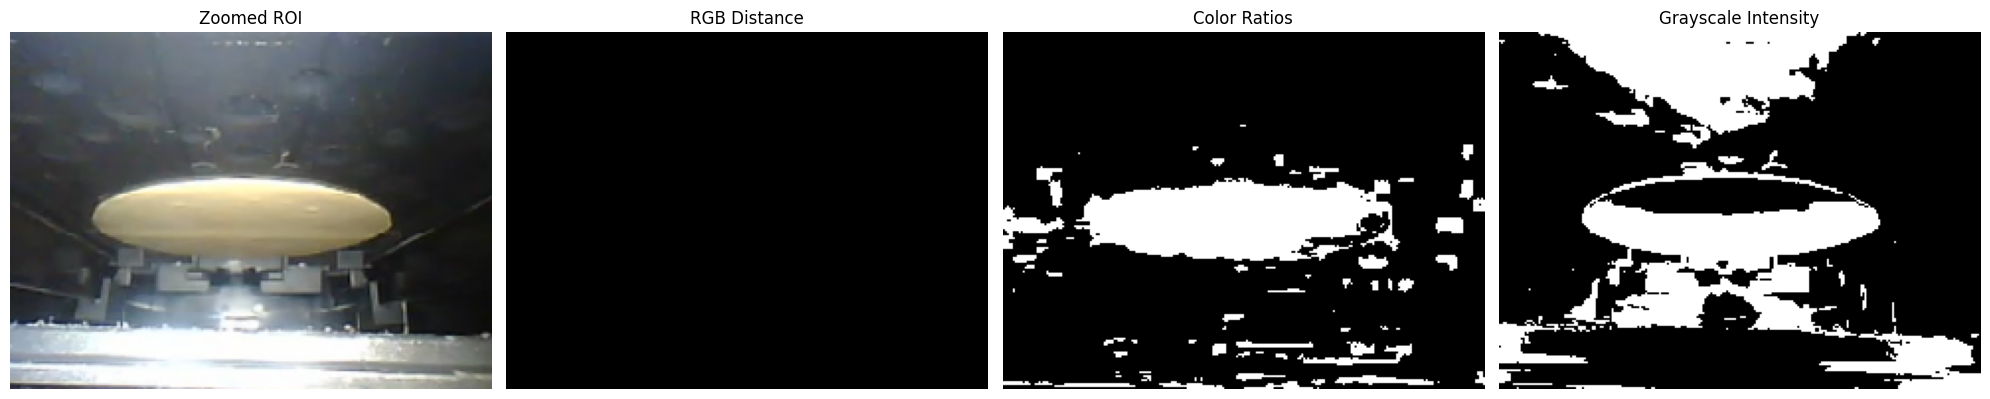

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image = Image.open("pos100.jpg")
image_array = np.array(image)
height, width, _ = image_array.shape

# Step 2: Define zoomed ROI (optional, for testing smaller areas)
roi_scale = 0.5
roi_width = int(width * roi_scale)
roi_height = int(height * roi_scale)
x_offset = (roi_width - width) // 2
y_offset = (roi_height - height) // 2

x_start = max(0, -x_offset)
x_end = min(width, width + x_offset)
y_start = max(0, -y_offset)
y_end = min(height, height + y_offset)
roi = image_array[y_start:y_end, x_start:x_end]

# Step 3: Define the target color and methods for detection
target_color = np.array([194, 178, 128])  # Example RGB for sand-brown

# --- Methods for Mask Creation ---
### Method 1: Euclidean Distance in RGB Space
def mask_by_rgb_distance(image, target_color, tolerance=50):
    distance = np.sqrt(
        (image[..., 0] - target_color[0]) ** 2 +
        (image[..., 1] - target_color[1]) ** 2 +
        (image[..., 2] - target_color[2]) ** 2
    )
    return distance < tolerance

### Method 2: Color Ratios
def mask_by_color_ratios(image):
    r_g_ratio = image[..., 0] / (image[..., 1] + 1e-5)
    r_b_ratio = image[..., 0] / (image[..., 2] + 1e-5)
    g_b_ratio = image[..., 1] / (image[..., 2] + 1e-5)
    
    return (
        (r_g_ratio > 1.0) & (r_g_ratio < 1.6) &
        (r_b_ratio > 1.0) & (r_b_ratio < 1.7) &
        (g_b_ratio > 0.7) & (g_b_ratio < 1.4)
    )


### Method 4: Grayscale-Based Contrast Analysis
def mask_by_grayscale_intensity(image, lower_gray=100, upper_gray=150):
    gray_image = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
    return (gray_image >= lower_gray) & (gray_image <= upper_gray)

# --- Generate Masks ---
# Mask 1: RGB Distance
mask_rgb = mask_by_rgb_distance(roi, target_color, tolerance=60)

# Mask 2: Color Ratios
mask_ratios = mask_by_color_ratios(roi)

# Mask 3: k-Nearest Neighbors
reference_colors = np.array([
    [194, 178, 128],  # Sand-brown 1
    [210, 190, 140],  # Sand-brown 2
    [180, 160, 120],  # Sand-brown 3
])


# Mask 4: Grayscale Contrast
mask_gray = mask_by_grayscale_intensity(roi, lower_gray=100, upper_gray=180)

# --- Visualize All Masks ---
masks = {
    "RGB Distance": mask_rgb,
    "Color Ratios": mask_ratios,
    "Grayscale Intensity": mask_gray,
}

fig, axes = plt.subplots(1, len(masks) + 1, figsize=(20, 5))

# Original Image
axes[0].imshow(roi)
axes[0].set_title("Zoomed ROI")
axes[0].axis("off")

# Visualize Each Mask
for i, (method_name, mask) in enumerate(masks.items(), start=1):
    axes[i].imshow(mask, cmap="gray")
    axes[i].set_title(method_name)
    axes[i].axis("off")

plt.tight_layout()
plt.show()